<a href="https://colab.research.google.com/github/DanNadler/speech_recognition/blob/main/speech_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pydub

In [ ]:
!pip install speechpy

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import scipy
import pydub
import scipy
import librosa
import speechpy

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
from tensorflow.keras import datasets, layers, models

# Data loading

In [ ]:
ds, info = tfds.load('speech_commands', split=['train', 'validation', 'test'], shuffle_files=True, with_info=True, as_supervised=True, data_dir="./drive/MyDrive/speech_commands")

In [ ]:
ds[0].cache()
ds[1].cache()
ds[2].cache()

<CacheDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.int16, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
train = ds[0]
validation = ds[1]
test = ds[2]

In [ ]:
print(type(train))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


# Data processing

In [ ]:
def feature_normalize(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu) / sigma

In [ ]:
train_pairs = []
sr = 16000
labels_number = 12
for example, label in train:
  scale = example.numpy()
  if len(scale)==16000:
    scale_float = scale.astype(np.float32)
    mfcc = librosa.feature.mfcc(y=scale_float, sr=sr, n_mfcc=64, n_fft=400, hop_length=160)
    mfcc_cmvn = speechpy.processing.cmvnw(mfcc.T, win_size=301, variance_normalization=True)
    label_one_hot = [0]*labels_number
    label_one_hot[label]=1
    label_one_hot = np.array(label_one_hot)
    train_pairs.append((mfcc_cmvn.T, label_one_hot))






In [ ]:
from numpy import asarray
from numpy import save
import os

In [ ]:
#save preprocessed train data to the drive
train_save = asarray(train_pairs)
np.save(os.path.join('./drive/MyDrive/preprocessed', 'train_set.npy'), train_save)

In [ ]:
from numpy import load
train_pairs = load('./drive/MyDrive/preprocessed/train_set.npy', allow_pickle=True)

In [ ]:
validation_pairs = []
sr = 16000
labels_number = 12
for example, label in validation:
  scale = example.numpy()
  if len(scale)==16000:
    scale_float = scale.astype(np.float32)
    mfcc = librosa.feature.mfcc(y=scale_float, sr=sr, n_mfcc=64, n_fft=400, hop_length=160)
    mfcc_cmvn = speechpy.processing.cmvnw(mfcc.T,win_size=301,variance_normalization=True)
    label_one_hot = [0]*labels_number
    label_one_hot[label]=1
    label_one_hot = np.array(label_one_hot)
    validation_pairs.append((mfcc_cmvn.T, label_one_hot))

In [ ]:
#save preprocessed validation data to the drive
validation_save = asarray(validation_pairs)
np.save(os.path.join('./drive/MyDrive/preprocessed', 'validation_set.npy'), validation_save)

In [ ]:
validation_pairs = load('./drive/MyDrive/preprocessed/validation_set.npy', allow_pickle=True)

In [ ]:
test_pairs = []
sr = 16000
labels_number = 12
for example, label in test:
  scale = example.numpy()
  if len(scale)==16000:
    scale_float = scale.astype(np.float32)
    mfcc = librosa.feature.mfcc(y=scale_float, sr=sr, n_mfcc=64, n_fft=400, hop_length=160)
    mfcc_cmvn = speechpy.processing.cmvnw(mfcc.T,win_size=301,variance_normalization=True)
    label_one_hot = [0]*labels_number
    label_one_hot[label]=1
    label_one_hot = np.array(label_one_hot)
    test_pairs.append((mfcc_cmvn.T, label_one_hot))

In [ ]:
#save preprocessed test data to the drive
test_save = asarray(test_pairs)
np.save(os.path.join('./drive/MyDrive/preprocessed', 'test_set.npy'), test_save)

<ipython-input-15-c0b4a65679e3>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_save = asarray(test_pairs)


In [ ]:
test_pairs = load('./drive/MyDrive/preprocessed/test_set.npy', allow_pickle=True)

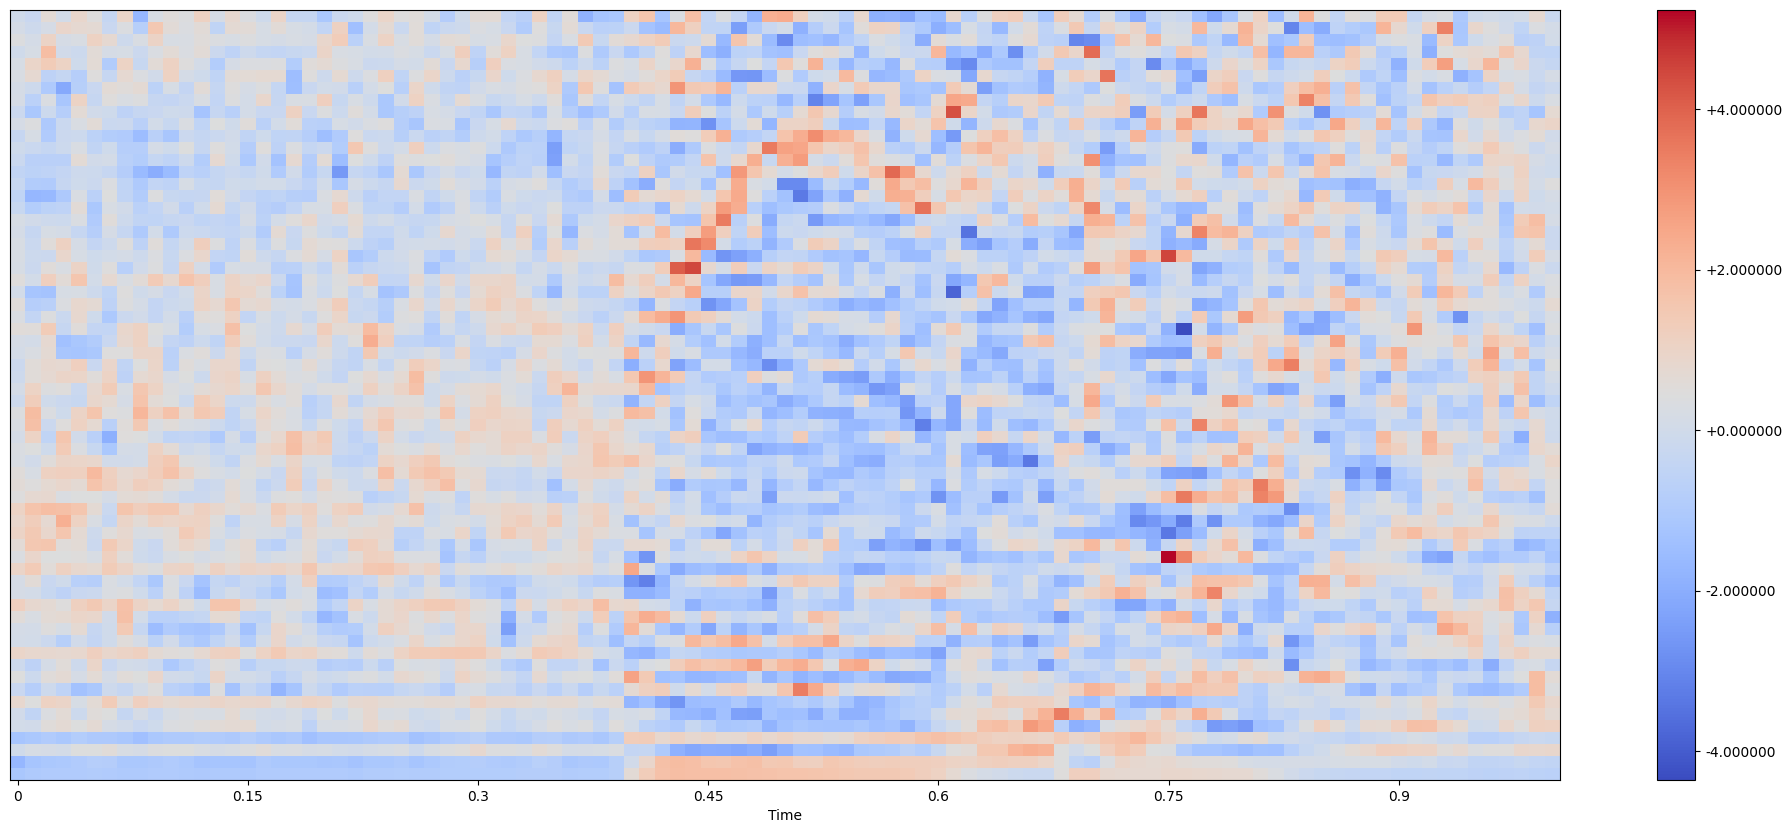

In [ ]:
plt.figure(figsize=(25, 10))
librosa.display.specshow(train_pairs[0][0], x_axis="time", sr=16000, n_fft=400, hop_length=160)
plt.colorbar(format="%+2f")
plt.show()

In [ ]:
images, labels = zip(*train_pairs)
with tf.device('GPU/:0'):
  labels = tf.constant(labels)
  images = tf.constant(images)
  train_dataset = tf.data.Dataset.from_tensor_slices((images, labels))

In [ ]:
images, labels = zip(*validation_pairs)
with tf.device('GPU/:0'):
  labels = tf.constant(labels)
  images = tf.constant(images)
  validation_dataset = tf.data.Dataset.from_tensor_slices((images, labels))

In [ ]:
images, labels = zip(*test_pairs)
with tf.device('GPU/:0'):
  labels = tf.constant(labels)
  images = tf.constant(images)
  test_dataset = tf.data.Dataset.from_tensor_slices((images, labels))

# defining the model:

In [ ]:
shape = train_pairs[0][0].shape

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(64,kernel_size=(17, 17), padding='valid', input_shape=(shape[0], shape[1], 1)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation(tf.keras.activations.relu))
model.add(tf.keras.layers.MaxPooling2D())
#model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, kernel_size=(13, 13), padding='valid'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation(tf.keras.activations.relu))
#model.add(layers.Dropout(0.15))
model.add(tf.keras.layers.MaxPooling2D())
model.add(layers.Conv2D(64, kernel_size=(6, 10), padding='valid'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation(tf.keras.activations.relu))
model.add(layers.Flatten())
model.add(layers.Dense(120))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation(tf.keras.activations.relu))
model.add(layers.Dense(12, activation='softmax'))


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 85, 64)        18560     
                                                                 
 batch_normalization (Batch  (None, 48, 85, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 48, 85, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 42, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 30, 64)        692288    
                                                                 
 batch_normalization_1 (Bat  (None, 12, 30, 64)        2

In [ ]:
with tf.device('GPU/:0'):
  train_dataset = train_dataset.shuffle(len(train_pairs)).batch(32, drop_remainder=True)
  validation_dataset = validation_dataset.batch(32, drop_remainder=True)


In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

In [ ]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

# Training the model:

In [ ]:
initial_learning_rate = 0.05
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=16000,
    decay_rate=0.96,
    staircase=True)

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

In [ ]:
optimizer1 = tf.keras.optimizers.SGD(learning_rate=0.00001)

In [ ]:
def loss(model, x, y):
  y_ = tf.reshape(model(x), [1, 32, 12])
  return loss_object(y_true=y, y_pred=y_)

In [ ]:
with tf.device('/GPU:0'):
  number_of_epochs = 200
  NUM_CLASSES = 12
  BATCH_SIZE = 32

  for i in range(number_of_epochs):
    right_pred = []
    loss_list = []
    counter = 0
    for example_batch, label_batch in train_dataset:
      example_batch = np.array(example_batch)
      label_batch = np.array(label_batch)
      example_batch = tf.convert_to_tensor(example_batch.reshape(-1, shape[0], shape[1], 1))
      label_batch = tf.convert_to_tensor(label_batch.reshape(1, BATCH_SIZE, NUM_CLASSES))
      y_pred = tf.reshape(model(example_batch), [1, BATCH_SIZE, NUM_CLASSES])
      loss_value, grads = grad(model, example_batch, label_batch)
      if i==0 and counter<200:
        print(counter)
        optimizer1.apply_gradients(zip(grads, model.trainable_variables))
      else:
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
      optimizer.apply_gradients(zip(grads, model.trainable_variables))
      counter+=1
      loss_list.append(loss_value)
      y_pred_np = y_pred.numpy().reshape(BATCH_SIZE, NUM_CLASSES)
      label_batch_np = label_batch.numpy().reshape(BATCH_SIZE, NUM_CLASSES)
      pred = [np.argmax(label)==np.argmax(pred) for label, pred in zip(label_batch_np, y_pred_np)]
      right_pred.extend(pred)
    print(f"the loss value of iteration {i+1}: {np.mean(loss_list)}")
    print(f"accracy value of this iteration {i+1}:{np.mean(right_pred)}")
    counter+=1
    if True:
      predictions = []
      true_labels = []
      for example_batch, label_batch in validation_dataset:
        example_batch = np.array(example_batch)
        label_batch = np.array(label_batch)
        example_batch = tf.convert_to_tensor(example_batch.reshape(-1, shape[0], shape[1], 1))
        label_batch = tf.convert_to_tensor(label_batch)
        y_pred = tf.math.argmax(model(example_batch), 1).numpy().tolist()
        y_true = tf.math.argmax(label_batch, 1).numpy().tolist()
        predictions.extend(y_pred)
        true_labels.extend(y_true)
      print(predictions)
      print(true_labels)
      recall = [0] * NUM_CLASSES
      update_op_rec = [[]] * NUM_CLASSES
      for k in range(NUM_CLASSES):
        m = tf.keras.metrics.Recall()
        m.update_state(tf.equal(true_labels, k), tf.equal(predictions, k))
        recall[k] = m.result().numpy()
      print(f"recall of every class in the validation in itertion {i+1} is:")
      print(recall)
      right_pred = [label==prediction for label, prediction in zip(true_labels, predictions)]
      print(f"validation accracy value of iteration {i+1} is :{np.mean(right_pred)}")
      model.save_weights(f"./drive/MyDrive/weights/goodcheckpoints3/my_checkpoint{i}")




0


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
the loss value of iteration 1: 1.0960265398025513
accracy value of this iteration 1:0.6860199418363108
[11, 11, 11, 11, 11, 5, 0, 11, 11, 11, 11, 9, 11, 11, 11, 11, 9, 11, 11, 11, 0, 11, 6, 11, 6, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 6, 11, 3, 1, 6, 11, 11, 0, 11, 11, 11, 11, 11, 11, 11, 8, 11, 11, 3, 11, 11

KeyboardInterrupt: 

In [ ]:
model.save_weights('./drive/MyDrive/weights/goodcheckpoints/my_checkpoint')

In [ ]:
model.load_weights('./drive/MyDrive/weights/goodcheckpoints3/my_checkpoint40')

In [ ]:
with tf.device('GPU/:0'):
  test_dataset = test_dataset.batch(32, drop_remainder=True)

In [ ]:
NUM_CLASSES = 12
BATCH_SIZE = 32
right_pred = []
for example_batch, label_batch in test_dataset:
  example_batch = np.array(example_batch)
  label_batch = np.array(label_batch)
  example_batch = tf.convert_to_tensor(example_batch.reshape(BATCH_SIZE, shape[0], shape[1], 1))
  label_batch = tf.convert_to_tensor(label_batch)
  y_pred = tf.math.argmax(model(example_batch), 1).numpy().tolist()
  y_true = tf.math.argmax(label_batch, 1).numpy().tolist()
  right_pred_add = [i==j for i, j in zip(y_pred, y_true)]
  right_pred.extend(right_pred_add)
print(f"test accuracy value:{np.mean(right_pred)}")

test accuracy value:0.8739720394736842
